In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools

import warnings
warnings.simplefilter('ignore')

***Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.***

In [2]:
Path_Energy = 'D:/AI/Machine learning/my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_m = data.resample('M').mean()
data_m.tail(3)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2018-06-30,32014.469444,2018.0,6.0,15.500000,2.0,166.500000,24.200000,3.100000,11.500000,0.000000,0.000000,0.000000
2018-07-31,36696.737903,2018.0,7.0,16.000000,3.0,197.000000,28.580645,2.935484,11.500000,0.032258,0.032258,0.032258
2018-08-31,39331.795918,2018.0,8.0,1.530612,3.0,213.530612,31.000000,2.530612,11.265306,0.000000,0.000000,0.000000


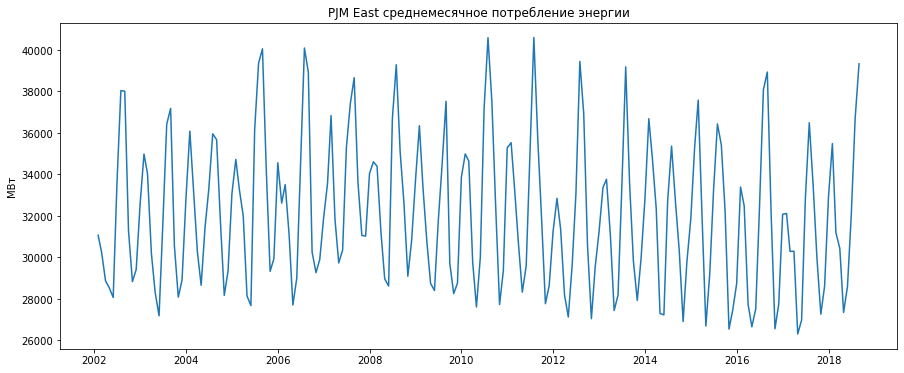

In [4]:
plt.figure(figsize =(15, 6))
plt.plot( data_m.index, data_m['PJME_MW'].values)
plt.title('PJM East среднемесячное потребление энергии')
plt.ylabel ('МВт');

***Подберите параметры модели SARIMAX для этого ряда.***

Автокорреляция на месячных данных за 3 года

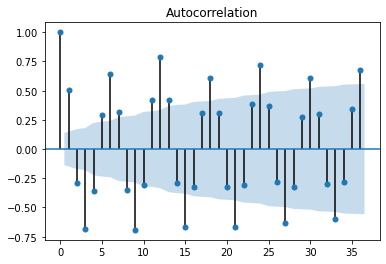

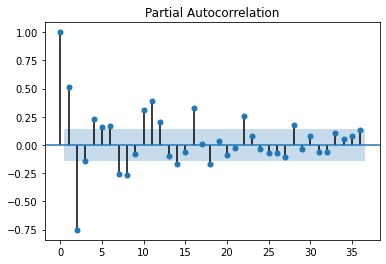

In [5]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=12*3)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=12*3)
plt.show()

Наблюдается корреляция для квартальных лагов, наибольшие значения корреляции между годовыми значениями, а для разностей важными являются значения внутри первых 3.

параметры

In [6]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)

# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [9]:
aic_ = 10000
param_ = None 
param_seasonal_ = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values,
                                    order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
            
            results = mod.fit()
            if results.aic < aic_:
                aic_ = results.aic
                param_ = param 
                param_seasonal_ = param_seasonal
        except:
            continue
print('SARIMAX {} x {} - AIC: {}'.format(param_, param_seasonal_, aic_))

SARIMAX (1, 1, 2) x (1, 2, 2, 12) - AIC: 2654.692194719888


Построим модель с подобранными параметрами

In [10]:
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values, 
                                order=param_,
                                seasonal_order=param_seasonal_,
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[0], results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  200
Model:             SARIMAX(1, 1, 2)x(1, 2, 2, 12)   Log Likelihood               -1320.346
Date:                            Sat, 16 May 2020   AIC                           2654.692
Time:                                    13:24:30   BIC                           2675.673
Sample:                                         0   HQIC                          2663.217
                                            - 200                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

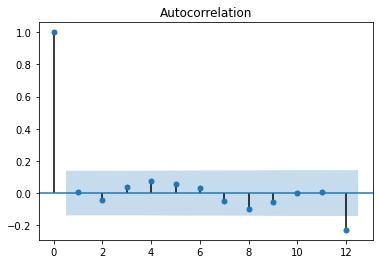

In [11]:
sm.graphics.tsa.plot_acf(results.resid, lags=12);

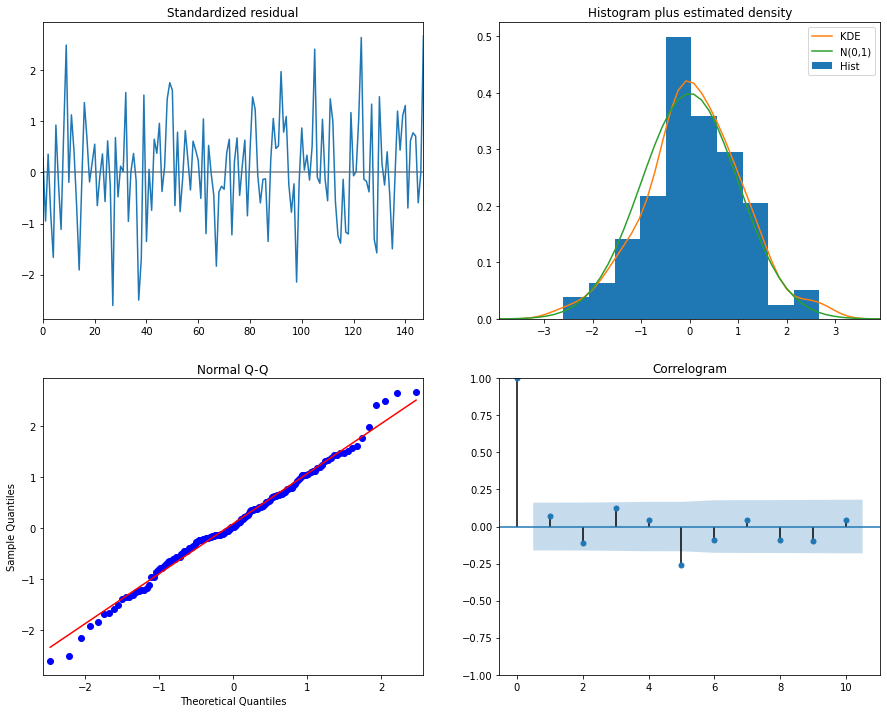

In [12]:
results.plot_diagnostics(figsize=(15, 12));

### Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Месячная модель дает лучшие результаты по сравнению с недельной